## Feature selection
### An artificial example to demonstrate feature selection based on maximizing validation $R^2$, rather than p-values.

If the dimension of feature space is high w.r.t. number of observations:
- become too specifically adjusted to the training set (overfitting), which would reduce its generalizeability (performance on the validation/test set);\\
- lead to multicollinearity of regressors and high variance in their estimates, making coefficients hard to interpret.



Reducing complexity of the model (number of features or their dimensionality) is usually recommended in such cases. The most streighforward way of doing so is through feature selection. 


In the beginning, we show a simple way of feature selection by p value.

Then, select a subset of the regressors of the given size $k$ maximizing the model fit ($R^2$).
Step-forward
Step-backward

Let's remind you:


The regular $R^2$:
$$
R^2=1-\frac{RSS}{\sum_i (y_i-\bar{y})^2}=\frac{\sum_i (\hat{y}_i-\bar{y})^2}{\sum_i (y_i-\bar{y})^2},
$$
The adjusted $R^2$:
$$
adj.R^2=1-\frac{RSS}{\sum_i (y_i-\bar{y})^2} \cdot \frac{N-1}{N-K-1} 
$$
where $N$ is the total sample size and $K$ is the number of features/selected variables

In [6]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from scipy.stats import t
n = 15
np.random.seed(1418)

col = []
for i in range(n):
    col.append('x%d'%(i+1))

X = pd.DataFrame(np.random.randn(50*n).reshape(50,n))
Y = X.ix[:,:3].sum(axis = 1) + np.random.randn(50)
data3 = pd.concat((Y,X), axis = 1)  # concatenate Y and X
data3.columns = ['Y'] + col         # rename the columns

In [7]:
data3.head()

,Y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15
0,-0.202926,0.365319,0.531999,2.012991,-1.928292,0.665695,1.610366,1.286302,-1.491848,-0.186504,-0.434291,0.578691,-0.682073,-1.967105,-0.168580,0.738449
1,0.582701,-0.417713,-0.836029,0.862249,0.761295,0.979998,-0.058929,0.629516,-0.343809,0.964349,0.458259,-0.417285,0.534536,-1.306485,0.417115,0.228568
2,-2.304904,-1.726257,0.141441,-0.111324,-0.876752,-0.856212,-0.749920,2.642533,-0.806439,-0.451594,0.501329,-0.522455,-1.086199,0.818685,1.086720,-0.430576
3,2.481421,1.468339,0.748165,-0.901341,0.258177,2.304412,-1.696290,0.111233,0.195310,-1.504150,1.277832,-1.057342,0.510799,0.447986,-0.326564,-0.150709
4,1.939502,0.721962,-0.631036,-0.336022,1.105122,-0.895231,-0.627360,0.740546,0.065552,0.140565,-0.676039,0.486579,-0.082139,-0.107791,-1.643315,-0.536591


In [8]:
# The regression function based on the feature selection
def AdjR2(flag):
    '''
    Evalute the model with adjusted R-squared,
    with flag indicating the feature selection
    1--feature included
    0--feature excluded
    '''
    formstr='Y~-1'
    for i in range(len(flag)):
        if flag[i]==1:
            formstr += '+x%d'%(i+1) # Construct the regression formula based on flag
    train = data3[:20]
    valid = data3[20:]
    lm = smf.ols(formula = formstr, data = train).fit()
    lmy = lm.predict(valid)
    y_err = lmy-valid.Y
    y_norm = valid.Y-np.mean(valid.Y)
    # Adjusted R^2
    R2 = 1 - y_err.dot(y_err) / y_norm.dot(y_norm) * (n-1) / (n-sum(flag)-1)
    return R2, lm

In [9]:
#AdjR2(np.array([1]+[0]*14))[0]
#print AdjR2(np.array([1]+[0]*14))[1].summary()

In [10]:
adjR2 = []
regR2 = []
for i in range(1, n):
    a,b = AdjR2([1]*i + [0]*(n-i))
    regR2.append(b.rsquared)
    if a>0:
        adjR2.append(a)
    else:
        adjR2.append(0)

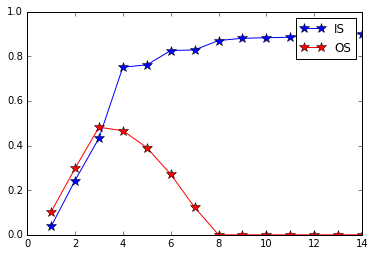

In [11]:
import matplotlib.pylab as plt
%matplotlib inline
# In sample R2
plt.plot(range(1, n), regR2, 'b-*', markersize = 10,label="IS")
# Out of sample R2 (adjusted)
plt.plot(range(1, n), adjR2, 'r-*', markersize = 10,label="OS")
plt.legend()
plt.show()

In [12]:
# Feature selection based on the p-values
def DropP(threshold = 1):
    '''Drop all features with p-values higher than the threshold'''
    flag_p = (AdjR2([1]*n)[1]).pvalues < threshold
    print('Validation R^2 is %f'%AdjR2(flag_p)[0])
    print(AdjR2(flag_p)[1].summary())

### First of all, let's try to include all features and observe their p-values
Note that if we include them all, we have a nagative one (N-N-1) in the denominator (since N = K), 
$$
adj.R^2=1-\frac{RSS}{\sum_i (y_i-\bar{y})^2} \cdot \frac{N-1}{N-K-1} 
$$
which simply flips the sign of the second term of the right hand side, making the adjusted $R^2$ ridiculously high

In [13]:
# DropP(1)

### If we remove variables based on their p-value (if > 0.2), then we'll keep $x_1,x_3,x_4,x_9,x_{15}$, and the model's out of sample $R^2$ is 0.097692

In [14]:
# DropP(0.2)

### Next we try to select feature in a fashion that maximizing validation adjusted $R^2$



In [15]:
# Find the best feature selection that maximizes the out-of-sample adjusted R2
def FindBestI():
    flag = np.zeros(n)    # initially exclude all regressors: 1-include, 0-exclude
    r2max = 0             # for storing and compare with best R^2
    while True:
        flag_mat = np.maximum(np.eye(n),flag)
        # see if R2 increases if we add one more feature
        r2 = np.apply_along_axis(AdjR2,1,flag_mat)[:,0]  # 1: row-wise operation, then select R2 only
        temp = r2.max()
        if temp > r2max:
            r2max = temp
            flag = flag_mat[r2.argmax()]  # select this feature if it improves our R2
        else:
            break                         # if there's nothing to add, break the loop
    return flag

flag = FindBestI()             # store the best choice of feature selection
r2_best,lm_best = AdjR2(flag)  # then run the regression based on such selection
ix = [col[i] for i in range(n) if flag[i]==1]

b = pd.DataFrame({'Pvalues':AdjR2([1]*n)[1].pvalues, 'Keeper':col})
c = 'forestgreen'
def highlight_pval(val):
    color = c if val in ix else 'white'
    return 'background-color: %s'%color

b.style.applymap(highlight_pval, subset=['Keeper']).\
    bar(subset = ['Pvalues'], color=c)

### The length of green bar in right column indicates the p-value, and we can see that despite having high p-value,  $x_1$ is still included in our "best fit", which accurately reflects our true model that $y \sim x_1 + x_2 + x_3$

In [16]:
print('Validation R^2 is %f'%r2_best)
print(lm_best.summary())

Validation R^2 is 0.481907
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     4.324
Date:                Wed, 12 Oct 2016   Prob (F-statistic):             0.0194
Time:                        19:56:17   Log-Likelihood:                -35.002
No. Observations:                  20   AIC:                             76.00
Df Residuals:                      17   BIC:                             78.99
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.7465    

#### Question: Maybe it is a special cut? We will see in next example.

# 2 Principle component analysis

Feature selection is often too rigid - we have to make our choices of keeping or getting rid of each variable entirely, though it might be the case that each regressor by itself still contains certain valuable information, but all together the feature space is redundant. As an alternative one can think of expressing our big amount of regressors through some smaller amount of latent variables (other than initial regressors) able to explain all or almost all the relevant information. This is called dimensionality reduction.

A most common linear approach to dimentionality reduction is the principal component analysis. An idea is that given $N$ observations for the $n$ regressors $x_j$

$$
X=\{x_i^j, i=1..n, j=1..N\}
$$

we try to come up with a linear transformation

$$
U=X V,
$$

where $V$ is $nxp$-dimensional transformation matrix and $U$ is a $N x p$ matrix of new factors $u_1,u_2,...,u_p$ (columns of $U$), such that they explain as much of initial information contained in $X$ as possible for the $p$ latent variables. 

## Technique

Before applying PCA variables $x_i$ are usually centered ($E[x_i]=0$) and sometimes also normalized ($var[x_i]=1$).

Selecting first principle component: look for the column unit basis $N x 1$ vector of weights/loadings $v_1$, such that resulting variable $u_1=X v_1$ has maximal possible variance $var[u_1]$:

$$
v_1=argmax_{v_1: v_1^T v_1=1}var[u_1] =argmax_{v_1: v_1^T v_1=1}u_1^T u_1=argmax_{v_1: v_1^T v_1=1}v_1^T X^T X v_1.
$$

The after first basis vector $v_1$ and principle component $u_1$ are selected, the second basis vector $v_2$ is selected following the same principle, but with an additional constrain of being orthogonal to $v_1$. 

Similarly each following $i$-th vector $v_i$ is being defined as
$$
v_i=argmax_{v_i: v_i^T v_i=1, v_i^T v_j=0, j<i}v_i^T X^T X v_i.
$$

The problem is easy to solve knowing the eigenvectors of $X^T X$, i.e. such unit vectors $v_i$ ($v_i^T v_i=1$) that

$$
\lambda_i v_i=X^T X v_i
$$

or in the matrix form

$$
diag(\lambda)V=X^T X V
$$

where $\lambda_i$ are the corresponding eigenvalues (mutually distinctive). First of all its easy to see that such vectors $v_i$ are always mutually orthogonal, as

$$
v_j^T v_i= v_j^T X^T X v_i/\lambda_i =(X^T X w_j)^T v_i/\lambda_i=v_j^T v_i \lambda_j/\lambda_i.
$$

This is why $V^T V=I_n$.

Now if we know $n$ unit eigenvectors with distinct eigenvalues such that $\lambda_1>\lambda_2> ...>\lambda_n>0$, they produce an orthogonal basis in the $n$-dimensional space and for any unit vector $w=e_1 v_1+e_2 v_2+... +e_n v_n$ we can see that

$$
w^T X^T X w=\lambda_1 e_1^2+\lambda_2 e_2^2+...+\lambda_n e_n^2,
$$

which is maximized for $e_1=1, e_2=e_3=...e_n=0$ (as $\sum_i e_i^2=1$), i.e. $w=v_1$. 

Similarly the second, third, etc loading vectors could be found as $v_2,v_3,...$ correspondingly.

Also the solution follows from the singular value decomposition of the matrix $X$:

$$
X=W \Sigma V^T,
$$

where $W$ is a $N x n$ matrix of mutually orthogonal unit columns, $V$ is a $n x n$ matrix of mutually orthogonal unit columns and $\Sigma$ is an $n x n$- diagonal matrix, i.e.

$$
W^T W=V^T V=I_n
$$

Then

$$
X^T X=V\Sigma W^T W \Sigma V^T=V\Sigma^2 V^T
$$

and its easy to see that $V$ is the matrix of eigenvectors and $\Sigma$ is the diagonal matrix of square roots of eigenvalues. Then 

$$
U=XV=W\Sigma V^T V=W\Sigma.
$$

## PCA as a dimensionality reduction tool

Now once matrixes $V, U, \Sigma$ are defined as well as the eigenvalues $\lambda_j$ (being the squares of the diagonal elements of $\Sigma$), how do we use that for dimensionality reduction? 

Matrix $V$ performs a transformation of the regressors $x_i$ to the new orthogonal variables $u_i$ being the columns of $U$. And 
$$
Var[u_i]=\lambda_i
$$

This is interpreted as each variable $u_i$ containing the fraction $\lambda_i/\sum\limits_j \lambda_j$ of the entire information (variation) contained in all the regressors. And the choice of regressors $u_i$ is such that $\lambda_1,\lambda_2,...$ are sequentially maximized. So if one wants to select as few latent variables as possible in order to cover a given franction $\alpha$ (often $95\%$) of information (variation) from it is enough to select first $k$ principle components $u_1,u_2,...u_k$, so that 

$$
\frac{\sum\limits_{i=1}^k\lambda_i}{\sum\limits_{i=1}^n\lambda_i}\geq \alpha.
$$






In [1]:
#import modules we need to use for this session
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
# PCA module
from sklearn.decomposition import PCA

### Example 1: Toy example to understand PCA

#### (1) create some data and plot 

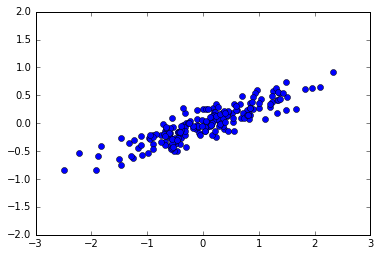

In [5]:
np.random.seed(1)
X = np.dot(np.random.random(size=(2, 2)), np.random.normal(size=(2, 200))).T
plt.plot(X[:, 0], X[:, 1], 'o')
plt.axis('equal');

#### (2) principal components
(in this particular example ~97.6% of the variance is preserved if we project down to the leading principal component)

In [19]:
print("total variance:{}".format(np.sum(np.var(X,0))))
pca = PCA(2)
pca.fit(X)
print("variance explained via the first and second components:{}\n".format(pca.explained_variance_))
print("principal components:\n{}".format(pca.components_))
#pca.explained_variance_ratio_
#np.var(X,0)

total variance:0.7771043494141933
variance explained via the first and second components:[ 0.75871884  0.01838551]

principal components:
[[ 0.94446029  0.32862557]
 [ 0.32862557 -0.94446029]]


#### (3) let's plot the two principal components

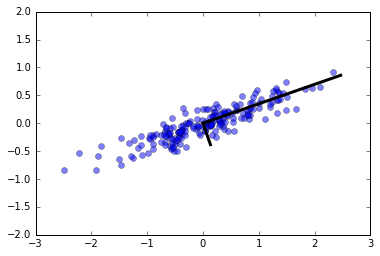

In [20]:
plt.plot(X[:, 0], X[:, 1], 'o', alpha=0.5)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    plt.plot([0, v[0]], [0, v[1]], '-k', lw=3)
plt.axis('equal');

#### (4)let's project the data onto the first principal component

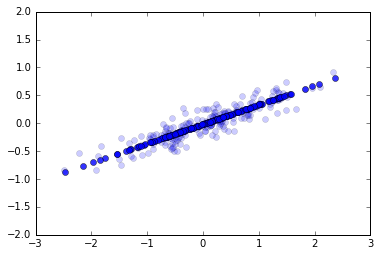

In [21]:
clf = PCA(0.95) # keep 95% of variance. This is another way to define the hyperparameters.
X_trans = clf.fit_transform(X)
X_new = clf.inverse_transform(X_trans) # transformed data
plt.plot(X[:, 0], X[:, 1], 'o', alpha=0.2)
plt.plot(X_new[:, 0], X_new[:, 1], 'ob', alpha=0.8)
plt.axis('equal');

#### (5) let's project the data onto the second principal component 

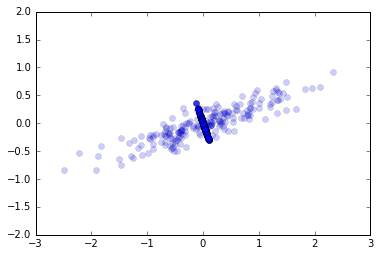

In [22]:
e2=pca.components_[1,:] # this is the 2nd eigenvector
X_new2=(np.dot(X,e2)*e2.reshape((2,1))).T  # this is the data projected onto the 2nd eigenvector
plt.plot(X[:, 0], X[:, 1], 'o', alpha=0.2)
plt.plot(X_new2[:, 0], X_new2[:, 1], 'ob', alpha=0.8)
plt.axis('equal');

### Quick example to show dimension reduction by PCA 

Iris dataset:
https://en.wikipedia.org/wiki/Iris_flower_data_set

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA

# import some data to play with
iris = datasets.load_iris()
X = iris.data  # we only take the first two features.
Y = iris.target
data_i=pd.DataFrame(np.concatenate((Y.reshape(len(Y),1),X),axis=1))
data_i.columns=["Species","Sepal_lenth","Sepal_width","Petal_length","Petal_width"]
data_i.head()

,Species,Sepal_lenth,Sepal_width,Petal_length,Petal_width
0,0.0,5.1,3.5,1.4,0.2
1,0.0,4.9,3.0,1.4,0.2
2,0.0,4.7,3.2,1.3,0.2
3,0.0,4.6,3.1,1.5,0.2
4,0.0,5.0,3.6,1.4,0.2


<img src="https://upload.wikimedia.org/wikipedia/commons/5/56/Kosaciec_szczecinkowaty_Iris_setosa.jpg",width=100,height=100>
<img src="https://upload.wikimedia.org/wikipedia/commons/4/41/Iris_versicolor_3.jpg",width=100,height=100>
<img src="https://upload.wikimedia.org/wikipedia/commons/9/9f/Iris_virginica.jpg",width=100,height=100>


#### Now what if we want to visulize the data?

In [24]:
#Covariance between X.
pd.DataFrame(X).corr()

,0,1,2,3
0,1.000000,-0.109369,0.871754,0.817954
1,-0.109369,1.000000,-0.420516,-0.356544
2,0.871754,-0.420516,1.000000,0.962757
3,0.817954,-0.356544,0.962757,1.000000


[ 0.92461621  0.05301557  0.01718514  0.00518309]


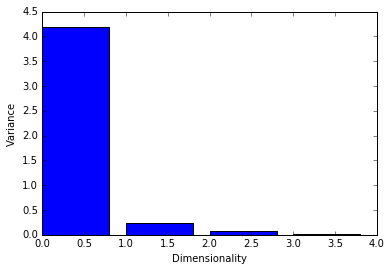

In [26]:
n=4 # how many eigenvectors we choose
from sklearn.decomposition import PCA
pca = PCA(n)
Xproj = pca.fit_transform(X)
eigenvalues = pca.explained_variance_
print (pca.explained_variance_ratio_)
plt.bar(np.arange(n), eigenvalues);
plt.xlabel("Dimensionality")
plt.ylabel("Variance")
plt.show()

### A. Reduce the dimension from 4 to 2 and plot it. 

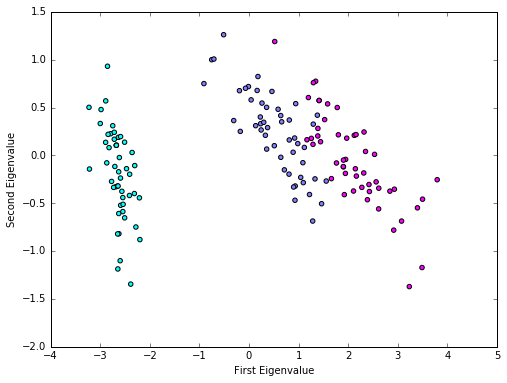

In [27]:
plt.figure(2, figsize=(8, 6))
plt.clf()
# Plot the training points
plt.scatter(Xproj[:, 0], Xproj[:, 1], c=Y, cmap=plt.cm.cool)
plt.xlabel('First Eigenvalue')
plt.ylabel('Second Eigenvalue')
plt.show()

### Reduce the dimension from 4 to 3 and plot it. 

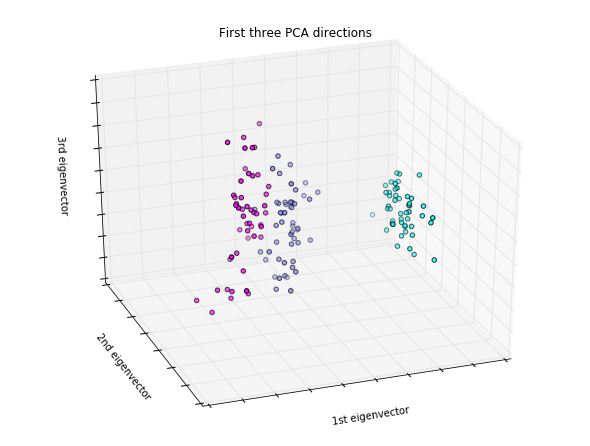

In [28]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(Xproj[:, 0], Xproj[:, 1], Xproj[:, 2], c=Y,
           cmap=plt.cm.cool)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

#### Example 2: Artificial data (Using PCA as feature selection tool)

In [9]:
data=pd.read_csv("https://serv.cusp.nyu.edu/~lw1474/ADS_Data/session06/data_q1.csv")

In [10]:
data.head(3)

,y,0,1,2,3,4,5,6,7,8,...,15,16,17,18,19,20,21,22,23,24
0,3.035437,-18.227424,30.521149,-37.494755,31.108940,-8.917930,13.177162,10.153335,17.521327,14.695400,...,11.332401,-3.530624,14.702212,14.099834,4.037464,12.604090,4.788002,9.592441,7.887213,9.061646
1,1.479243,31.210052,8.273238,17.545475,8.013616,-3.163515,12.632948,10.384905,7.278064,11.506060,...,5.867968,6.762153,11.128908,6.466586,10.245606,10.736484,5.349025,21.841173,-3.204046,19.017705
2,-1.193325,-2.427634,1.698858,-1.980364,-9.902694,9.215057,9.984092,7.627307,7.701929,15.254064,...,15.241884,4.876780,13.953317,11.608533,7.515592,3.413471,12.893463,1.633385,21.345764,7.264307


In [11]:
x=data.iloc[:,1:]
y=np.asarray(data.y)

In [13]:
#1. What the corr matrix
# x.corr()

In [19]:
#2. Multivariable regression. y~X (No intercept).

#(1) sklearn
from sklearn.linear_model import LinearRegression
ols=LinearRegression(fit_intercept=False)
ols.fit(x,y)
print (ols.coef_)

[  5.21154801e+00  -7.71586608e+00  -6.41754995e+00   5.19593674e+00
   7.33642207e+00   7.36951614e-03  -6.98303604e-02  -1.44688377e-01
   3.00169434e-02  -4.12361635e-02  -1.18981035e-02   6.45369557e-02
  -6.78464950e-02  -1.51716838e-01   3.43346746e-02   3.36169411e-02
   4.05397263e-02   3.33329948e-02  -1.12002841e-01   4.07332717e-03
  -1.32373703e-02  -4.22958382e-02   3.26439504e-03  -1.65213589e-02
   4.23871855e-02]


In [17]:
#(2) statsmodels for the same y~x. 
import statsmodels.api as sm
res=sm.OLS(y,x).fit()
print (res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     4.857
Date:                Sun, 23 Oct 2016   Prob (F-statistic):           9.40e-05
Time:                        15:29:04   Log-Likelihood:                -56.791
No. Observations:                  50   AIC:                             163.6
Df Residuals:                      25   BIC:                             211.4
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
0              5.2115      2.704      1.927      0.0

####  The R-squared looks very good?? (Before we go ahead, let's take a quick look at feature selection)

In [21]:
### feature selection by p-values.
res=sm.OLS(y,x.iloc[:,[7,13,18]]).fit()
print (res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                    0.1903
Date:                Sun, 23 Oct 2016   Prob (F-statistic):              0.902
Time:                        15:30:34   Log-Likelihood:                -100.68
No. Observations:                  50   AIC:                             207.4
Df Residuals:                      47   BIC:                             213.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
7             -0.0041      0.048     -0.084      0.9

### Overfitting problem

In [26]:
# Using cross validation.
R_IS=[]
R_OS=[]

# Why we need this? let's set n=1 and run several times to see.
n=1000
from sklearn.cross_validation import train_test_split
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)
    
    res=LinearRegression(fit_intercept=False)
    res.fit(X_train,y_train)
    R_IS.append(1-((np.asarray(res.predict(X_train))-y_train)**2).sum()/((y_train-np.mean(y_train))**2).sum())                                                                     
    R_OS.append(1-((np.asarray(res.predict(X_test))-y_test)**2).sum()/((y_test-np.mean(y_test))**2).sum())
print("IS R-squared for {} times is {}".format(n,np.mean(R_IS)))
print("OS R-squared for {} times is {}".format(n,np.mean(R_OS)))

IS R-squared for 1000 times is 0.9117874165998913
OS R-squared for 1000 times is -0.9049519211245123


In [27]:
# Using cross validation after feature selection.
R_IS=[]
R_OS=[]
n=1000
from sklearn.cross_validation import train_test_split
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(np.asarray(x.iloc[:,[7,13,18]]), y, test_size=0.33)
    res=LinearRegression(fit_intercept=False)
    res.fit(X_train,y_train)
    R_IS.append(1-((np.asarray(res.predict(X_train))-y_train)**2).sum()/((y_train-np.mean(y_train))**2).sum())                                                                     
    R_OS.append(1-((np.asarray(res.predict(X_test))-y_test)**2).sum()/((y_test-np.mean(y_test))**2).sum())
print("IS R-squared for {} times is {}".format(n,np.mean(R_IS)))
print("OS R-squared for {} times is {}".format(n,np.mean(R_OS)))

IS R-squared for 1000 times is 0.007777346046430731
OS R-squared for 1000 times is -0.26546522084328406


### PCA

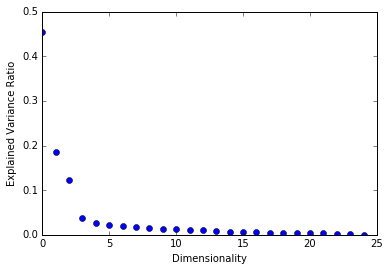

In [28]:
n=25 # how many eigenvectors we choose
from sklearn.decomposition import PCA
pca = PCA(n)
Xproj = pca.fit_transform(x)
eigenvalues = pca.explained_variance_ratio_
plt.plot(np.arange(n), eigenvalues, 'o')
plt.xlabel("Dimensionality")
plt.ylabel("Explained Variance Ratio")
plt.show()

In [30]:
#Correlation between variabls in Xproj after transformation.
# pd.DataFrame(Xproj).corr()

In [32]:
import statsmodels.api as sm
res=sm.OLS(y,pd.DataFrame(Xproj)).fit()
print (res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     6.519
Date:                Sun, 23 Oct 2016   Prob (F-statistic):           6.58e-06
Time:                        15:33:02   Log-Likelihood:                -50.548
No. Observations:                  50   AIC:                             151.1
Df Residuals:                      25   BIC:                             198.9
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
0              0.0200      0.004      5.214      0.0

In [34]:
# What about the feature selection this time?
import statsmodels.api as sm
res=sm.OLS(y,pd.DataFrame(Xproj).iloc[:,[0,1,3]]).fit()
print (res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     16.65
Date:                Sun, 23 Oct 2016   Prob (F-statistic):           1.66e-07
Time:                        15:33:53   Log-Likelihood:                -82.885
No. Observations:                  50   AIC:                             171.8
Df Residuals:                      47   BIC:                             177.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
0              0.0200      0.005      3.744      0.0

In [35]:
# Using cross validation.Looks much better compared to first one if you remember.
R_IS=[]
R_OS=[]
n=1000
from sklearn.cross_validation import train_test_split
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(Xproj[:,[0,1,3]], y, test_size=0.4)
    res=LinearRegression(fit_intercept=False)
    res.fit(X_train,y_train)
    R_IS.append(1-((np.asarray(res.predict(X_train))-y_train)**2).sum()/((y_train-np.mean(y_train))**2).sum())                                                                     
    R_OS.append(1-((np.asarray(res.predict(X_test))-y_test)**2).sum()/((y_test-np.mean(y_test))**2).sum())
print("IS R-squared for {} times is {}".format(n,np.mean(R_IS)))
print("OS R-squared for {} times is {}".format(n,np.mean(R_OS)))

IS R-squared for 1000 times is 0.5023698243442111
OS R-squared for 1000 times is 0.3638789954768607


### Real Example

Before we tried to use some parameters of the house (size) to predict its price. However notice that location matters as well. Below we upload a sample (approximately 30% of the total) of more than 2000 individual house sales all around NYC in 2012. Each record together with the parameters of the house also contains important characteristics of the location (zip code) - average income of its residents (accodring to US census), as well as the relative structure of 311 complaints happening in the area.

In [38]:
data4=pd.read_csv("https://serv.cusp.nyu.edu/~lw1474/ADS_Data/session06/example4.csv").iloc[:,2:]
data4.loc[:,["zip_code","sale_price","gross_sq_feet","mean"]].head()

,zip_code,sale_price,gross_sq_feet,mean
0,11356,600000,1624,80098.0
1,10017,5200000,3840,149723.0
2,11413,100000,2120,84085.0
3,11213,775000,3423,46614.0
4,11207,151000,2136,44634.0


### OLS 

In [39]:
# Run a linear regression: "sale_price"~"gross_sq_feet"+"mean"
import statsmodels.api as sm
res=sm.OLS(data4.sale_price,sm.add_constant(data4.loc[:,["gross_sq_feet","mean"]]),missing="drop").fit()
print (res.summary())


                            OLS Regression Results                            
Dep. Variable:             sale_price   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     883.7
Date:                Sun, 23 Oct 2016   Prob (F-statistic):          1.62e-287
Time:                        15:47:16   Log-Likelihood:                -36359.
No. Observations:                2375   AIC:                         7.272e+04
Df Residuals:                    2372   BIC:                         7.274e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const         -2.569e+06    9.2e+04    -27.913

In [35]:
#If using sklearn.
lm=LinearRegression()
lm.fit(data4.loc[:,["gross_sq_feet","mean"]],data4.sale_price)
lm.coef_

In [36]:
# Using cross validation to show average R-squared
R_IS=[]
R_OS=[]
n=100
from sklearn.cross_validation import train_test_split
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(data4.loc[:,["gross_sq_feet","mean"]],data4.sale_price,test_size=0.3)
    res=LinearRegression(fit_intercept=False)
    res.fit(X_train,y_train)
    R_IS.append(1-((np.asarray(res.predict(X_train))-y_train)**2).sum()/((y_train-np.mean(y_train))**2).sum())                                                                     
    R_OS.append(1-((np.asarray(res.predict(X_test))-y_test)**2).sum()/((y_test-np.mean(y_test))**2).sum())
print("IS R-squared for {} times is {}".format(n,np.mean(R_IS)))
print("OS R-squared for {} times is {}".format(n,np.mean(R_OS)))

#### Q1: How to increase average OS R-squared to get a better prediction?
#### Q2: How to get a better estimated coefficient for sale_price~gross_sq_feet

### Add all 311 data

#### 311 service requests data.
https://en.wikipedia.org/wiki/3-1-1

3-1-1 is a special telephone number supported in many communities in Canada and the United States. The number provides access to non-emergency municipal services. The number format follows the N11 code for a group of short, special-purpose local numbers as designated in the North American Numbering Plan.
The number 3-1-1 is intended in part to divert routine inquiries and non-urgent community concerns from the 9-1-1 number which is reserved for emergency service. A promotional website for 3-1-1 in Akron described the distinction as follows: "Burning building? Call 9-1-1. Burning Question? Call 3-1-1."

In [40]:
list_311=list(data4.loc[:,"Adopt A Basket":"X Ray Machine Equipment"].columns)
data5=data4[["sale_price","gross_sq_feet","mean"]+list_311]
#list_311
#data5.head()

In [34]:
# Run "sale_price"~"gross_sq_feet"+"mean"+"all 311" What is new R-squared? Remove constant.
res=sm.OLS(data4.sale_price,sm.add_constant(data4.loc[:,["gross_sq_feet","mean"]+list_311]),missing="drop").fit()

# Take a look p values if you are interested by following code
print (res.summary())

                            OLS Regression Results                            
Dep. Variable:             sale_price   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     135.8
Date:                Wed, 12 Oct 2016   Prob (F-statistic):               0.00
Time:                        20:02:29   Log-Likelihood:                -34378.
No. Observations:                2375   AIC:                         6.903e+04
Df Residuals:                    2238   BIC:                         6.982e+04
Df Model:                         136                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------------

### Show Over-fitting problem 

In [35]:
#Step one: Split the data to training and testing data: Using "train_test_split", and set random_state=324 and test_size=0.3
X_train, X_test, y_train, y_test = train_test_split(data5.loc[:,"gross_sq_feet":],data5.sale_price,random_state=324,test_size=0.3)

#Step two: train the model again using training data.

res=sm.OLS(y_train,sm.add_constant(X_train),missing="drop").fit()
# print res.rsquared()
print("IS-R-squared:{}".format(res.rsquared))

res=LinearRegression(fit_intercept=False)
res.fit(X_train,y_train)
print("IS-R-squared:{}".format(1-((np.asarray(res.predict(X_train))-y_train)**2).sum()/((y_train-np.mean(y_train))**2).sum()))                                                                   

#Step three: Get the out of sample prediction, and calculate Out of sample R-squared, and compare it to insample R-squared.
print("OS-R-squared:{}".format(1-((np.asarray(res.predict(X_test))-y_test)**2).sum()/((y_test-np.mean(y_test))**2).sum()))

NameError: name 'train_test_split' is not defined

In [43]:
#Step four: try 100 times random split the data and get the average OS and IS R-squared
R_IS=[]
R_OS=[]
n=100
from sklearn.cross_validation import train_test_split
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(data5.loc[:,"gross_sq_feet":],data5.sale_price,test_size=0.3)
    res=LinearRegression(fit_intercept=False)
    res.fit(X_train,y_train)
    R_IS.append(1-((np.asarray(res.predict(X_train))-y_train)**2).sum()/((y_train-np.mean(y_train))**2).sum())                                                                     
    R_OS.append(1-((np.asarray(res.predict(X_test))-y_test)**2).sum()/((y_test-np.mean(y_test))**2).sum())
print("IS R-squared for {} times is {}".format(n,np.mean(R_IS)))
print("OS R-squared for {} times is {}".format(n,np.mean(R_OS)))

### Let's using PCA on 311 data. 

In [41]:
data6=data5.loc[:,"Adopt A Basket":]
data6.head()

,Adopt A Basket,Air Quality,Animal Abuse,Animal Facility No Permit,Animal in a Park,APPLIANCE,Asbestos,Beach Pool Sauna Complaint,BEST Site Safety,Bike Rack Condition,...,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Window Guard,X Ray Machine Equipment
0,0.000000,0.027721,0.0,0.000000,0.000770,0.000257,0.001027,0.001797,0.001540,0.000000,...,0.000000,0.000000,0.000000,0.001797,0.001540,0.003850,0.002053,0.049281,0.0,0.0
1,0.000000,0.010675,0.0,0.000000,0.000227,0.000227,0.003861,0.000000,0.001363,0.000000,...,0.000227,0.000227,0.000000,0.010675,0.000454,0.001817,0.000227,0.050874,0.0,0.0
2,0.000000,0.002511,0.0,0.000000,0.001076,0.001973,0.000359,0.000000,0.000359,0.000000,...,0.000000,0.000000,0.004484,0.000000,0.000179,0.007354,0.001256,0.069058,0.0,0.0
3,0.000000,0.001476,0.0,0.000000,0.000170,0.006756,0.000738,0.000057,0.000227,0.000114,...,0.000170,0.000170,0.000908,0.000568,0.000170,0.000454,0.000341,0.012433,0.0,0.0
4,0.000049,0.001671,0.0,0.000049,0.000344,0.006143,0.000688,0.000000,0.000541,0.000049,...,0.000491,0.000197,0.005897,0.000590,0.000393,0.001622,0.000442,0.037445,0.0,0.0


In [60]:
# Find the correlation matrix for data6.
#data6.corr()

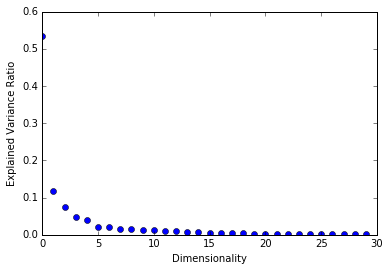

In [42]:
# Plot the biggest 30 eigenvalues.
n=30
from sklearn.decomposition import PCA
pca = PCA(n)
Xproj = pca.fit_transform(data6)
eigenvalues = pca.explained_variance_ratio_
plt.plot(np.arange(n), eigenvalues, 'o')
plt.xlabel("Dimensionality")
plt.ylabel("Explained Variance Ratio")
plt.show()

In [48]:
# Transform data6 to the top 6 eigenspace and merge the new data back to "gross_sq_feet" and "mean" and run the regression again.
X=pd.concat((data5[["gross_sq_feet","mean"]],pd.DataFrame(Xproj[:,:6])),axis=1)
y=data5["sale_price"]

In [46]:
#Look at the linear regression result
#X.corr()

In [45]:
res1=sm.OLS(y,sm.add_constant(X),missing="drop").fit()
print (res1.summary())

                            OLS Regression Results                            
Dep. Variable:             sale_price   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     353.3
Date:                Sun, 23 Oct 2016   Prob (F-statistic):               0.00
Time:                        15:50:15   Log-Likelihood:                -36087.
No. Observations:                2375   AIC:                         7.219e+04
Df Residuals:                    2366   BIC:                         7.224e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const         -3.006e+06   1.28e+05    -23.467

In [46]:
R_IS=[]
R_OS=[]
n=100
from sklearn.cross_validation import train_test_split
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4)
    res=LinearRegression(fit_intercept=False)
    res.fit(X_train,y_train)
    R_IS.append(1-((np.asarray(res.predict(X_train))-y_train)**2).sum()/((y_train-np.mean(y_train))**2).sum())                                                                     
    R_OS.append(1-((np.asarray(res.predict(X_test))-y_test)**2).sum()/((y_test-np.mean(y_test))**2).sum())
print("IS R-squared for {} times is {}".format(n,np.mean(R_IS)))
print("OS R-squared for {} times is {}".format(n,np.mean(R_OS)))

IS R-squared for 100 times is 0.44955024202316535
OS R-squared for 100 times is 0.36389350009957283


### What if we want explain sale_price~gross_sq_feet in a more convincing way? (Let's do it if we have time left)